# Glucose Metrics

This notebook calculates all-time and daily glucose metrics from blood glucose readings held in the Health Tracker database and retrieved via the Health Tracker Web Service.

Before attempting to run the notebook:

- Make sure the variables defined in "config.ipynb" are set correctly
- Set the reporting date range and export options in the first code cell

In [21]:
from datetime import date, timedelta

# Reporting date range
start = date(2025, 4, 17)
end = start + timedelta(days=11)

# Whether to export the data to a spreadsheet
export_spreadsheet = True

# Export format for the chart:
# PNG     - export as PNG image
# PDF     - export as PDF file
# <blank> - do not export
chart_export_format = "PNG"

In [22]:
# Define range limits
tar_1_lower = 10.1
tar_1_upper = 13.9
tar_2_lower = 14.0
tbr_1_lower = 3.0
tbr_1_upper = 3.8

# Metrics dictionary keys and dataframe column titles
MEAN = "Mean Glucose (mmol/L)"
SD = "SD (mmol/L)"
CV = "CV (%)"
GMI = "GMI (%)"
TIR = "Time in Range %"
TAR_1 = f"TAR ({tar_1_lower}–{tar_1_upper}) %"
TAR_2 = f"TAR (>= {tar_2_lower}) %"
TBR_1 = f"TBR ({tbr_1_lower}–{tbr_1_upper}) %"
TBR_2 = f"TBR (< {tbr_1_lower}) %"


In [23]:
%run ../api.ipynb
%run ../config.ipynb
%run ../export.ipynb

In [24]:
# Log in to the service, get the person ID and retrieve the data
token = authenticate(url, username, password)
person_id = get_person_id(url, token, firstnames, surname)
df = get_blood_glucose_measurements(url, token, person_id, start, end)

# Preview the data
df.head()

,level,id,personId,date
0,6.4,5561,1,2025-04-17 18:52:57
1,7.1,5562,1,2025-04-17 18:57:57
2,7.7,5563,1,2025-04-17 19:02:57
3,8.3,5564,1,2025-04-17 19:07:57
4,8.5,5565,1,2025-04-17 19:12:56


In [25]:
import pandas as pd
import numpy as np


def compute_metrics(measurements):
    # Drop the grouping column, if present
    measurements = measurements.drop(columns="date", errors="ignore")

    # Calculate the mean, standard deviation and variance
    mean_glucose = measurements["level"].mean()
    std_glucose = measurements["level"].std()
    cv = (std_glucose / mean_glucose) * 100 if mean_glucose else np.nan

    # Calculate mean glucose level in mg/dL and the GMI
    mean_mg_dl = mean_glucose * 18.0182
    gmi = 3.31 + 0.02392 * mean_mg_dl

    # Calculate the time in, above and below range
    total = len(measurements)
    tir = measurements["level"].between(3.9, 10.0).sum() / total * 100
    tar_1 = measurements["level"].between(10.1, 13.9).sum() / total * 100
    tar_2 = (measurements["level"] >= 14.0).sum() / total * 100
    tbr_1 = measurements["level"].between(3.0, 3.8).sum() / total * 100
    tbr_2 = (measurements["level"] < 3.0).sum() / total * 100

    # Create a dictionary of the metrics
    metrics = {
        MEAN: round(mean_glucose, 2),
        SD: round(std_glucose, 2),
        CV: round(cv, 1),
        GMI: round(gmi, 2),
        TIR: round(tir, 1),
        TAR_1: round(tar_1, 1),
        TAR_2: round(tar_2, 1),
        TBR_1: round(tbr_1, 1),
        TBR_2: round(tbr_2, 1),
    }

    # And return the metrics as a dataframe
    return pd.Series(metrics)

In [26]:
import pandas as pd

# Calculate all-time metrics
all_time_metrics_df = compute_metrics(df)

with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.precision", 3,
                       ):
    display(all_time_metrics_df)

Mean Glucose (mmol/L)     7.75
SD (mmol/L)               1.03
CV (%)                   13.20
GMI (%)                   6.65
Time in Range %          95.90
TAR (10.1–13.9) %         4.10
TAR (>= 14.0) %           0.00
TBR (3.0–3.8) %           0.00
TBR (< 3.0) %             0.00
dtype: float64

In [27]:
# Rename the date column to timestamp and sort the data 
df.rename(columns={ "date": "timestamp" }, inplace=True)
df = df.sort_values("timestamp")

# Add a "date" column
df["date"] = df["timestamp"].dt.date

# Group by date and calculate daily metrics
daily_metrics_df = (
    df[["date", "level"]]
    .groupby("date")
    .apply(compute_metrics, include_groups=False)
)

# Preview the data
daily_metrics_df.head()

,Mean Glucose (mmol/L),SD (mmol/L),CV (%),GMI (%),Time in Range %,TAR (10.1–13.9) %,TAR (>= 14.0) %,TBR (3.0–3.8) %,TBR (< 3.0) %
date,,,,,,,,,
2025-04-17,8.13,0.91,11.1,6.81,100.0,0.0,0.0,0.0,0.0
2025-04-18,7.71,1.24,16.1,6.63,93.4,6.6,0.0,0.0,0.0
2025-04-19,7.70,1.14,14.8,6.63,94.8,5.2,0.0,0.0,0.0
2025-04-20,8.37,0.99,11.8,6.92,92.7,7.3,0.0,0.0,0.0
2025-04-21,7.77,0.79,10.2,6.66,97.2,2.8,0.0,0.0,0.0


In [28]:
# Add a week column
df["week"] = df["timestamp"].dt.to_period("W").apply(lambda r: r.start_time.date())

# Group by date and calculate weekly metrics
weekly_metrics_df = (
    df
    .groupby("week")
    .apply(compute_metrics, include_groups=False)
)

# Preview the data
weekly_metrics_df.head()

,Mean Glucose (mmol/L),SD (mmol/L),CV (%),GMI (%),Time in Range %,TAR (10.1–13.9) %,TAR (>= 14.0) %,TBR (3.0–3.8) %,TBR (< 3.0) %
week,,,,,,,,,
2025-04-14,7.94,1.15,14.5,6.73,94.1,5.9,0.0,0.0,0.0
2025-04-21,7.66,0.94,12.3,6.61,96.9,3.1,0.0,0.0,0.0


In [29]:
# Export the data to a spreadsheet
if export_spreadsheet:
    export_to_spreadsheet("glucose_metrics", {
        "Daily": daily_metrics_df,
        "Weekly": weekly_metrics_df
    })

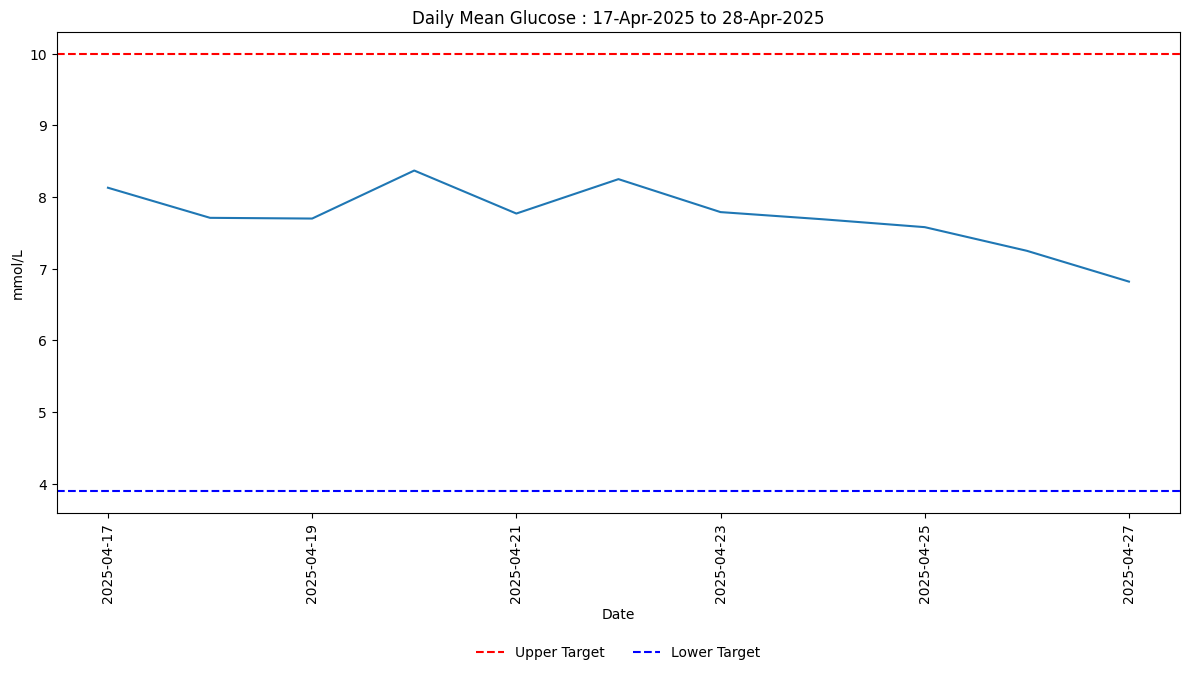

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the daily metrics
plt.figure(figsize=(12, 7))
sns.lineplot(data=daily_metrics_df, x=daily_metrics_df.index, y=MEAN)
plt.axhline(10.0, color="red", linestyle="--", label="Upper Target")
plt.axhline(3.9, color="blue", linestyle="--", label="Lower Target")

# Set labels and titles
plt.title(f"Daily Mean Glucose : {start.strftime('%d-%b-%Y')} to {end.strftime('%d-%b-%Y')}")
plt.ylabel("mmol/L")
plt.xlabel("Date")
plt.xticks(rotation=90)

# Move the legend below the plot
plt.legend(
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.25), 
    ncol=2,
    frameon=False
)

plt.tight_layout()

# Export to PNG or PDF, if required
export_chart("glucose_metrics", "Daily", chart_export_format)

# Show the plot
plt.show()
